# Recurrent Neural Network Benchmark
This experiment will calculate a benchmark for Recurrent Neural Networks. We will use a simple standard for this, so that we know how these networks perform before any tuning or modification.

LSTMs have been used in previous experiments, however this is the first one to use them on a substantial amount of data. For this reason we will treat this as our benchmark.

In [1]:
from scripts.feature_extraction import get_balanced_dataset, get_entire_dataset, scaled_reviewer_features
from notebooks.yelp.metrics import auroc, f1
from scripts.cross_validate import run_single_cross_validate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Concatenate, Dense, Embedding, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from keras import backend as K
from keras import regularizers

import numpy as np
import gensim
import sys
import nltk

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
# Set CROSS_FOLD_NUM to whichever fold you would like to run
CROSS_FOLD_NUM = 0
units = 10

In [3]:
all_reviews = get_balanced_dataset()

In [4]:
def clean_review_content(review_content):
      return " ".join([x for x in nltk.word_tokenize(review_content) if x.isalpha()])

reviews_contents = [clean_review_content(x.review_content) for x in all_reviews]
labels = [1 if x.label else 0 for x in all_reviews]

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews_contents)

In [6]:
corpus_words = tokenizer.word_index
corpus_vocab_size = len(corpus_words)+1

We create sequences necessary to compute word vectors from our embedding matrix:

In [7]:
predictors_sequences = pad_sequences(tokenizer.texts_to_sequences(reviews_contents))
max_len = max([len(x) for x in predictors_sequences])

We use pretrained word2vec vectors from Google, trained on a Google News corpus:

In [8]:
word_vectors = gensim.models.KeyedVectors.load_word2vec_format("../../data/GoogleNews-vectors-negative300.bin",
                                                               binary=True)

In [9]:
embedding_length = word_vectors.vector_size
embedding_matrix = np.zeros((corpus_vocab_size, embedding_length))
for word, index in corpus_words.items():
  if word in word_vectors.vocab:
    embedding_matrix[index] = np.array(word_vectors[word], dtype=np.float32)

In [13]:
reviewer_features = scaled_reviewer_features(all_reviews, get_entire_dataset('../../data/yelpZip'))

In [14]:
train_predictors_sequences = predictors_sequences[:-10000]
train_reviewer_features = reviewer_features[:-10000]
train_labels = labels[:-10000]

Our LSTM model is basic. A similar experiment was ran in a distributed form (outside of this notebook) with 512 units in the LSTM. This experiment was consistently less accurate, so the 10 units here remain.

In [10]:
def get_lstm_wv_model():
    i1 = Input(shape=(max_len,))
    i2 = Input(shape=(5,))

    l1 = Embedding(corpus_vocab_size, embedding_length, weights=[embedding_matrix], input_length=max_len, trainable=False)(i1)
    l2 = LSTM(units)(l1)
    l3 = Concatenate(axis=1)([l2, i2])
    l4 = tf.keras.layers.Dense(8, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))(l3)
    l5 = tf.keras.layers.Dense(8, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))(l4)
    l6 = tf.keras.layers.Dense(1, activation=sigmoid)(l5)
    model = Model(inputs=[i1, i2], outputs=l6)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', auroc, f1])
    return model

In [11]:
def evaluate_lstm_model(train_X, train_y, test_X, test_y):
    lstm_model = get_lstm_wv_model()
    lstm_model.fit([x for x in train_X], train_y, epochs=50, batch_size=256, validation_split=0.3, verbose=1, shuffle=False,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=6)])
    return lstm_model.evaluate([x for x in test_X], test_y)

In [ ]:
splitter = StratifiedKFold(n_splits=10, shuffle=True)
rnn_wv_scores = run_single_cross_validate(evaluate_lstm_model, [train_predictors_sequences, train_reviewer_features], train_labels,
                                          CROSS_FOLD_NUM, splitter, verbose=1, epochs=12, batch_size=64, shuffle=True)
print(rnn_wv_scores)

In [2]:
rnn_wv_scores

{'loss': [0.5550563013851826,
  0.5585482540537922,
  0.5585852593673146,
  0.5566633776662231,
  0.5582062198800604,
  0.5577220357677689,
  0.5678035712159235,
  0.5537652867940218,
  0.5664126500654939,
  0.5669196811269435],
 'accuracies': [0.7289891623051472,
  0.7294294089657924,
  0.7298384348107178,
  0.72915672507053,
  0.7251346376834695,
  0.7277251346498612,
  0.7226123116858143,
  0.7285431863315852,
  0.7266343990850647,
  0.7241120731036627],
 'auroc': [0.8003564126244366,
  0.8004373614024274,
  0.7999588248603761,
  0.79845744895749,
  0.7968711187189134,
  0.800911409587455,
  0.7920290507308666,
  0.802576947165517,
  0.7953940453407221,
  0.7948687213908844],
 'f1-score': [0.737453129115861,
  0.7419323356038295,
  0.7405435847223508,
  0.7410593826034999,
  0.7243894092899636,
  0.7329859303358638,
  0.7376336395533281,
  0.7446782862500542,
  0.7371903413789747,
  0.7443907539150012]}

Text(0.5, 1.0, 'Recurrent Neural Network Accuracies')

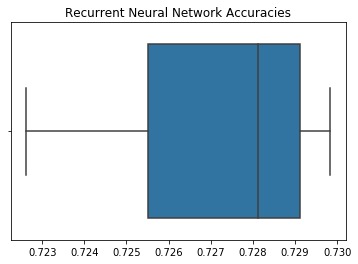

In [8]:
from seaborn import boxplot
from pandas import DataFrame
boxplot(DataFrame([rnn_wv_scores['accuracies']])).set_title("Recurrent Neural Network Accuracies")

Text(0.5, 1.0, 'Recurrent Neural Network AUC scores')

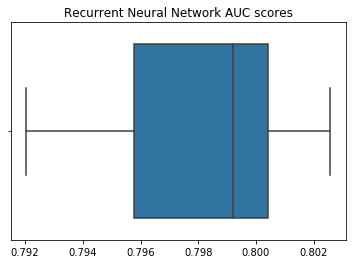

In [7]:
boxplot(DataFrame([rnn_wv_scores['auroc']])).set_title("Recurrent Neural Network AUC scores")

Text(0.5, 1.0, 'Recurrent Neural Network F1 scores')

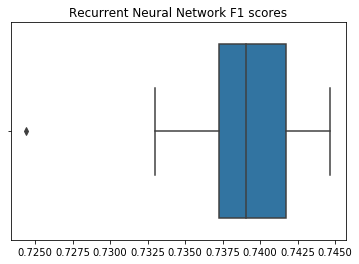

In [5]:
boxplot(DataFrame([rnn_wv_scores['f1-score']])).set_title("Recurrent Neural Network F1 scores")

These accuracies are higher than all previous neural benchmarking experiments. They are reliably between 68% and 70%, meaning that we can treat this as a benchmark for LSTM networks. Future modifications to the model can be compared to this to assess their effects.

In [ ]:
lstm_model = get_lstm_wv_model()
lstm_model.fit([train_predictors_sequences, train_reviewer_features], train_labels, epochs=25, batch_size=256, verbose=1, shuffle=False)

Epoch 1/25
146692/146692 [==============================] - 216s 1ms/step - loss: 0.6694 - acc: 0.6961 - auroc: 0.7535 - f1: 0.6970
Epoch 2/25
146692/146692 [==============================] - 215s 1ms/step - loss: 0.5848 - acc: 0.7202 - auroc: 0.7893 - f1: 0.7268
Epoch 3/25
146692/146692 [==============================] - 216s 1ms/step - loss: 0.5700 - acc: 0.7263 - auroc: 0.7966 - f1: 0.7340
Epoch 4/25
146692/146692 [==============================] - 215s 1ms/step - loss: 0.5625 - acc: 0.7299 - auroc: 0.8005 - f1: 0.7378
Epoch 5/25
146692/146692 [==============================] - 215s 1ms/step - loss: 0.5574 - acc: 0.7318 - auroc: 0.8033 - f1: 0.7396
Epoch 6/25
146692/146692 [==============================] - 215s 1ms/step - loss: 0.5533 - acc: 0.7331 - auroc: 0.8057 - f1: 0.7408
Epoch 7/25
146692/146692 [==============================] - 215s 1ms/step - loss: 0.5501 - acc: 0.7345 - auroc: 0.8076 - f1: 0.7421
Epoch 8/25
146692/146692 [==============================] - 216s 1ms/step - 

In [22]:
test_predictors_sequences = predictors_sequences[-10000:]
test_reviewer_features = reviewer_features[-10000:]
test_labels = labels[-10000:]

In [24]:
test_scores = lstm_model.evaluate([test_predictors_sequences, test_reviewer_features], test_labels)
test_scores

10000/10000 [==============================] - 20s 2ms/step


[0.557976548576355, 0.7214, 0.7950065410227588, 0.7183396739006043]